In [2]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [3]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import msgpack
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import msgpack
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
from scipy.stats import linregress

from src.common.AssetData import AssetData
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.mathTools.CurveAnalysis import CurveAnalysis
from src.predictionModule.CurveML import CurveML
from src.common.YamlTickerInOut import YamlTickerInOut
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO


In [4]:
assets: dict[str, AssetData] = AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")
current_date: pd.Timestamp = pd.Timestamp.now(tz='UTC')
analysis_results = []
for ticker, asset in assets.items():
    priceData: pd.DataFrame = asset.shareprice.iloc[-21*6:-1]["Close"]
    priceData = priceData.resample('B').mean().dropna()
    priceDataVal=priceData.values
    analysis_results.append(CurveAnalysis.lineFit(priceDataVal/priceDataVal[0], ticker))

res = pd.DataFrame(analysis_results)
res['Rankslope'] = res['Slope'].rank(ascending=False)
res['Rankvar'] = res['Variance'].rank(ascending=True)
res['Score'] = res['Rankslope'] + res['Rankvar']
res.sort_values(by='Score', ascending=True, inplace=True)

In [5]:
res

,Ticker,Slope,Intercept,R_Value,P_Value,Std_Err,Variance,Rankslope,Rankvar,Score
179,MSI,0.002923,0.989951,0.987115,9.408880e-100,0.000043,0.000295,32.0,3.0,35.0
25,T,0.003064,1.002770,0.974975,3.496478e-82,0.000063,0.000640,27.0,31.0,58.0
372,SPGI,0.002508,0.995562,0.970419,8.944183e-78,0.000056,0.000511,49.0,14.0,63.0
291,CTAS,0.002370,0.967654,0.966792,9.846196e-75,0.000056,0.000515,58.0,15.0,73.0
43,BRO,0.002548,1.015901,0.961911,3.905602e-71,0.000065,0.000688,47.0,39.0,86.0
...,...,...,...,...,...,...,...,...,...,...
307,LRCX,-0.001348,1.035439,-0.470012,3.199587e-08,0.000228,0.008412,367.0,381.0,748.0
93,EW,-0.002703,1.039483,-0.787979,1.122153e-27,0.000190,0.005855,385.0,370.0,755.0
8,ALB,-0.002996,1.077167,-0.761000,7.209997e-25,0.000230,0.008561,386.0,383.0,769.0
303,INTC,-0.003251,0.964166,-0.783796,3.247476e-27,0.000232,0.008707,387.0,384.0,771.0


{'Ticker': 'ZBRA', 'Slope': 20.032834797427036, 'Intercept': 7082.392465215774, 'R_Value': 0.9164300211673652, 'P_Value': 9.391949624021026e-51, 'Std_Err': 0.7887914146037602, 'Variance': 100445.10417056044}
LinregressResult(slope=20.032834797427036, intercept=7082.392465215774, rvalue=0.9164300211673652, pvalue=9.391949624021026e-51, stderr=0.7887914146037602, intercept_stderr=56.58444570323974)
7082.392465215774


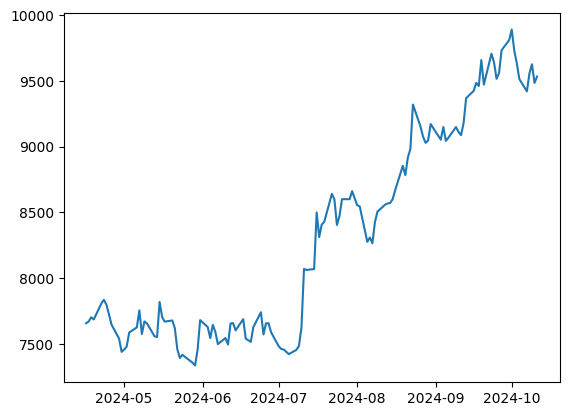

In [6]:
from scipy.stats import linregress
pdframe = assets["NVR"].shareprice.iloc[-21*6:-1]["Close"]
zeroval=pdframe.values[0]
plt.plot(pdframe)
a = CurveAnalysis.lineFit(pdframe.values, ticker)
print(a)
regression = linregress(np.arange(len(pdframe)), pdframe.values)
print(regression)
y_fit = regression.slope * np.arange(len(pdframe)) + regression.intercept
print(regression.intercept)

In [7]:
import polars as pl
from datetime import datetime, timedelta

# Generate sample data
start_date = datetime(2023, 1, 1)
data = {
    'timestamp': [start_date + timedelta(days=i) for i in range(10)],
    'price': [100 + i * 10 for i in range(10)]
}

priceData = pl.DataFrame(data)
print(priceData["price"].quantile(0.90))
print(type(priceData['price'].to_numpy()))

180.0
<class 'numpy.ndarray'>


In [8]:
print(pl.__version__)

1.9.0


In [9]:
# Resample to daily frequency and compute mean
resampled = priceData.group_by_dynamic(
    index_column='timestamp',
    every='1d',       # Window size of 1 day
    closed='left',    # Window is left-closed
    by=None           # No additional grouping
).agg([
    pl.col('price').mean().alias('price_mean')
]).drop_nulls()

print(resampled)

shape: (10, 2)
┌─────────────────────┬────────────┐
│ timestamp           ┆ price_mean │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ f64        │
╞═════════════════════╪════════════╡
│ 2023-01-01 00:00:00 ┆ 100.0      │
│ 2023-01-02 00:00:00 ┆ 110.0      │
│ 2023-01-03 00:00:00 ┆ 120.0      │
│ 2023-01-04 00:00:00 ┆ 130.0      │
│ 2023-01-05 00:00:00 ┆ 140.0      │
│ 2023-01-06 00:00:00 ┆ 150.0      │
│ 2023-01-07 00:00:00 ┆ 160.0      │
│ 2023-01-08 00:00:00 ┆ 170.0      │
│ 2023-01-09 00:00:00 ┆ 180.0      │
│ 2023-01-10 00:00:00 ┆ 190.0      │
└─────────────────────┴────────────┘


C:\Users\KILightTouch\AppData\Local\Temp\ipykernel_13696\2642637582.py:2: DeprecationWarning: The argument `by` for `DataFrame.group_by_dynamic` is deprecated. It has been renamed to `group_by`.
  resampled = priceData.group_by_dynamic(


In [10]:
# Add a weekday column (0=Monday, 6=Sunday)
priceData = priceData.with_columns([
    pl.col('timestamp').dt.weekday().alias('weekday')
])

# Filter to include only business days (Monday=0 to Friday=4)
business_days = priceData.filter(pl.col('weekday').is_between(0, 4))

# Perform resampling on business days
resampled_business = business_days.group_by_dynamic(
    index_column='timestamp',
    every='1d',       # 1 day window
    closed='left'
).agg([
    pl.col('price').mean().alias('price_mean')
]).drop_nulls()

# Drop the auxiliary 'weekday' column if not needed
resampled_business = resampled_business.drop('weekday') if 'weekday' in resampled_business.columns else resampled_business

print(resampled_business)

shape: (6, 2)
┌─────────────────────┬────────────┐
│ timestamp           ┆ price_mean │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ f64        │
╞═════════════════════╪════════════╡
│ 2023-01-02 00:00:00 ┆ 110.0      │
│ 2023-01-03 00:00:00 ┆ 120.0      │
│ 2023-01-04 00:00:00 ┆ 130.0      │
│ 2023-01-05 00:00:00 ┆ 140.0      │
│ 2023-01-09 00:00:00 ┆ 180.0      │
│ 2023-01-10 00:00:00 ┆ 190.0      │
└─────────────────────┴────────────┘


In [11]:
# Sample data
data = {
    "ID": range(1, 21),  # IDs from 1 to 20
    "Slope": np.random.uniform(0, 100, 20),      # Random Slope values between 0 and 100
    "Variance": np.random.uniform(10, 50, 20)    # Random Variance values between 10 and 50
}

# Create a Polars DataFrame
results_df = pl.DataFrame(data)

In [12]:
sectors = {}
for ticker, asset in assets.items():
    sectors[asset.about["sectorKey"]] = asset.about["sectorKey"]

assets["IRM"].about

{'address1': '85 New Hampshire Avenue',
 'address2': 'Suite 150',
 'city': 'Portsmouth',
 'state': 'NH',
 'zip': '03801',
 'country': 'United States',
 'phone': '617 535 4766',
 'website': 'https://www.ironmountain.com',
 'industry': 'REIT - Specialty',
 'industryKey': 'reit-specialty',
 'industryDisp': 'REIT - Specialty',
 'sector': 'Real Estate',
 'sectorKey': 'real-estate',
 'sectorDisp': 'Real Estate',
 'longBusinessSummary': "Iron Mountain Incorporated (NYSE: IRM) is a global leader in information management services. Founded in 1951 and trusted by more than 240,000 customers worldwide, Iron Mountain serves to protect and elevate the power of our customers' work. Through a range of offerings including digital transformation, data centers, secure records storage, information management, asset lifecycle management, secure destruction and art storage and logistics, Iron Mountain helps businesses bring light to their dark data, enabling customers to unlock value and intelligence from 